In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# SciKit-Learn packages
from sklearn.metrics import precision_score, accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance

# Stop words for NLP
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


# Custom functions used in Q2
from Q2Funcs import find_uniques, one_hot, column_score


#  In hoeverre is het mogelijk om op basis van plot keywords te voorspellen tot welke genres een film behoort?
# Casper

 

In [2]:
df_movies = pd.read_csv('../../data/movie.csv')
df_movies.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## 2. Data processing 
Alleen 'keywords' en 'genres' nodig.

In [3]:

# Ongewenste kolommen verwijderen
df_movies.drop(["movie_imdb_link", "aspect_ratio"], axis=1, inplace=True)

#Onduidelijke kolomnamen aanpassen
df_movies.rename(columns={'color': 'Colour',
                          'director_name': 'Director',
                          'num_critic_for_reviews': 'Number of critics',
                          'duration': 'Duration',
                          'director_facebook_likes': 'Director FB likes',
                          'actor_3_facebook_likes': 'Actor 3 FB likes',
                          'actor_2_name': 'Actor 2 name',
                          'actor_1_facebook_likes': 'Actor 1 FB likes',
                          'gross': 'Gross',
                          'genres': 'Genres',
                          'actor_1_name': 'Actor 1 name',
                          'movie_title': 'Movie title',
                          'num_voted_users': 'Number of voted users',
                          'cast_total_facebook_likes': 'Total Cast FB likes',
                          'actor_3_name': 'Actor 3 name',
                          'facenumber_in_poster': 'Number of faces on poster',
                          'plot_keywords': 'Plot Keywords',
                          'num_user_for_reviews': 'Number of user reviews',
                          'language': 'Language',
                          'country': 'Country',
                          'content_rating': 'Age rating',
                          'budget': 'Budget',
                          'title_year': 'Release year',
                          'actor_2_facebook_likes': 'Actor 2 FB likes',
                          'imdb_score': 'IMDB Score',
                          'movie_facebook_likes': 'Movie FB likes'}, inplace=True)

# Volgorde kolommen aanpassen
df_movies = df_movies[['Movie title',
                       'Release year',
                       'Director',
                       'Director FB likes',
                       'Gross',
                       'Budget',
                       'Duration',
                       'Language',
                       'Country',
                       'Colour',
                       'Genres',
                       'IMDB Score',
                       'Number of voted users',
                       'Number of critics',
                       'Number of user reviews',
                       'Age rating',
                       'Total Cast FB likes',
                       'Movie FB likes',
                       'Actor 1 name',
                       'Actor 2 name',
                       'Actor 3 name',
                       'Actor 1 FB likes',
                       'Actor 2 FB likes',
                       'Actor 3 FB likes',
                       'Plot Keywords',
                       'Number of faces on poster',
                       ]]

# Datatypen aanpassen
# 1. Floats omzetten naar integers
#  De dataset bevat geen kolommen die dienen te worden bewaard als float, behalve `IMDB Score`
df_movies_IMDB_Score = df_movies["IMDB Score"]  # Tijdelijke kopie van de kolom `IMDB Score`
df_movies = df_movies.drop('IMDB Score', axis=1).fillna(0).astype(int, errors='ignore') # Waarden omzetten naar integers
df_movies.insert(11, "IMDB Score", df_movies_IMDB_Score)  # `IMDB Score` weer toevoegen aan originele DataFrame
del df_movies_IMDB_Score

# 2. De kolom `Release year` omzettten van integers naar het datetime-datatype
df_movies["Release year"] = pd.to_datetime(df_movies["Release year"], format='%Y', errors='coerce')


## 3. Data Cleaning

In [4]:

# NaN-types verwijderen
df_movies.dropna(inplace=True)

# Dubbele titels verwijderen
df_movies.sort_values("Release year", inplace=True)  # Sorteren op uitgavejaar
df_movies.drop_duplicates(subset="Movie title", keep="last", inplace=True)  # Alleen meest recente versie blijft bewaard

# Negatieve waardes verwijderen
num = df_movies._get_numeric_data()
num[num < 0] = 0


## Q2. Genres voorspellen gebaseerd op Plot Keywords
De onderzoeksvraag gaat als volgt: 
> In hoeverre is het mogelijk om op basis van plot keywords te voorspellen tot welke genres een film behoort? 


### Q2. Data collection
Bij `Q2` wordt er gebruik gemaakt van de kolommen `Genres` en `Plot Keywords` uit `df_movies`. Om ervoor te zorgen dat bij andere onderzoeksvragen de DataFrame niet onnodig wordt aangepast, wordt de dataframe voor de zekerheid als een kopie aangeroepen. 

In [5]:
df_Q2 = df_movies.loc[:, ("Genres", "Plot Keywords")].copy()
df_Q2.head()

,Genres,Plot Keywords
4810,Drama|History|War,huguenot|intolerance|medicis|protestant|wedding
4958,Crime|Drama,family relationships|gang|idler|poorhouse|thief
4885,Drama|Romance|War,chewing gum|climbing a tree|france|translation...
2734,Drama|Sci-Fi,art deco|bible quote|dance|silent film|worker
4812,Musical|Romance,sibling rivalry|singer|sister act|whistling|wi...


### Q2. Data processing
Aangezien vrijwel alle machine learning algoritmen alleen algebraïsche datatypes accepteren, moeten zowel `Plot Keywords` als `Genres` ingrijpend veranderd worden. Beide zijn namelijk categoriale datatypes.


#### Q2. Cleaning voor processing


Na een korte inspectie van de data, kom je een aantal waardes van 0 en “0” tegen (`int` en `string`). Dit zijn missende waarden. 

Hoewel dit gewoonlijks in stap 3 van het Data Science proces gebeurt, is het in deze scenario beter om dit van tevoren te doen. De 0 en "0" zijn na deze stap namelijk moeilijker terug te vinden.



In [6]:
# All '0' are missing values, remove
df_Q2.replace("0", np.NaN, inplace=True)
df_Q2.replace(0, np.NaN, inplace=True)
df_Q2.dropna(inplace=True)

#### Q2. Terug naar processing
Om in de gebruikte modellen gebruik te maken van `Genres` en `Plot Keywords` moeten deze gecodeerd worden. 

Om dit te doen moeten de kolommen eerst gesplitst worden. Dit gaat op twee manieren. 

Van `Genres` wordt een lijst gemaakt, alle genres zijn namelijk opgebroken met behulp van een `|`. Dit resulteerd in de kolom `Split Genres`. Hetzelfde proces wordt toegepast bij `Plot Keywords`. Dit resulteerd in de kolom `Split Keywords`.

Bij `Plot Keywords` worden alle `|` vervangen met een spatie. Dit wordt later verder toegelicht.

Hoewel `Split Keywords` niet wordt gebruikt als input variabele, is deze alsnog handig om te hebben bij het analyseren van de data. 

In [7]:
# Split "Genres" by "|", creating list types
df_Q2.loc[:, "Split Genres"] = df_Q2["Genres"].str.split(pat="|")

# Replace "|" with " " to create strings analysable by TF-IDf.
df_Q2.loc[:, "Plot Keywords"] = df_Q2["Plot Keywords"].str.replace("|", " ")
# Split "Plot Keywords" by " ", creating list types
df_Q2.loc[:, "Split Keywords"] = df_Q2["Plot Keywords"].str.split(pat=" ")


df_Q2.head()

,Genres,Plot Keywords,Split Genres,Split Keywords
4810,Drama|History|War,huguenot intolerance medicis protestant wedding,"[Drama, History, War]","[huguenot, intolerance, medicis, protestant, w..."
4958,Crime|Drama,family relationships gang idler poorhouse thief,"[Crime, Drama]","[family, relationships, gang, idler, poorhouse..."
4885,Drama|Romance|War,chewing gum climbing a tree france translation...,"[Drama, Romance, War]","[chewing, gum, climbing, a, tree, france, tran..."
2734,Drama|Sci-Fi,art deco bible quote dance silent film worker,"[Drama, Sci-Fi]","[art, deco, bible, quote, dance, silent, film,..."
4812,Musical|Romance,sibling rivalry singer sister act whistling wi...,"[Musical, Romance]","[sibling, rivalry, singer, sister, act, whistl..."


In [8]:
pd.DataFrame([df_Q2["Split Genres"].str.len().describe(), df_Q2["Split Keywords"].str.len().describe()])

,count,mean,std,min,25%,50%,75%,max
Split Genres,4673.0,2.898138,1.191393,1.0,2.0,3.0,4.0,8.0
Split Keywords,4673.0,7.604751,2.453461,1.0,6.0,7.0,9.0,25.0


Er zijn gemiddeld drie genres en vijf plot keywords per film. Het is echter géén uniforme data. Zowel genres als plot keywords heeft een minimum van 1 woord (I.E. er is maar één genre of één plot keyword). Het maximaal aantal waarden voor genres is 8, het maximaal aantal waarden voor plot keywords is daarentegen 25. 


Een probleem met de vraagstelling is dat genres multilabel waardes zijn, een film dus heeft meer dan een genre. Alleen het eerste genre pakken is een mogelijkheid, maar dit zal de accuratesse van ons model zeer negatief beïnvloeden. De genres zijn namelijk niet gesorteerd op toepasbaarheid, maar alfabetisch. 

In [9]:
alphabetical = True
for value in df_Q2["Split Genres"].values:
    if value != sorted(value):
        alphabetical = False
        
alphabetical
    

True

Zowel genres als plot keywords is categorische data. Aangezien meeste machine learning modellen algebraïsch zijn, accepteren deze alleen numerieke data. Dat betekent dat zowel genres als keywords omgezet moet worden naar numerieke data. 

Dit wordt meestal doormiddel van ‘One-Hot’ encoding gedaan. Bij 'One-Hot' encoding wordt van iedere unieke waarde een eigen kolom gemaakt. Deze kolom heeft een waarde '1' of '0'. Of de waarde komt voor in `Genres`, of niet.

Dit veroorzaakt echter een probleem wanneer er sprake is van een grote variatie aan herhalende data. In deze scenario kan term frequency-inverse document frequency (TF-IDF) gebruikt worden.

TF-IDF genereerd namelijk waardes en kolommen gebaseerd op de frequentie van woorden in een string.

De volgende stap is om te kijken naar unieke waarden van zowel `Genres` als `Plot Keywords`. Gebaseerd op het aantal unieke waarden wordt de de codeertechniek gekozen.

In [10]:
genre_uniques = find_uniques(df_Q2["Split Genres"])
genre_uniques.describe()

,Count
count,24.000000
mean,564.291667
std,603.319980
min,2.000000
25%,164.000000
50%,367.500000
75%,834.500000
max,2396.000000


Het gaat hierbij dus om 24 unieke genres. Ook zullen genres niet meer dan één keer in een rij voorkomen. Bij `Genres` zal dus One-Hot encoding gebruikt worden.

In [11]:
key_uniques = find_uniques(df_Q2["Split Keywords"])
key_uniques.describe()

,Count
count,6104.000000
mean,5.821920
std,15.975298
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,323.000000


Er zijn in totaal 6104 unieke plot keywords. Bepaalde plot keywords zullen ook meerdere keren per rij voor kunnen komen. Bij `Plot Keywords` zal dus TF-IDF gebruikt worden.
#### Q2 Coderen van categoriale data
Beginnend met `Genres`, deze kolom wordt gecodeerd met behulp van One-Hot encoding.

In [12]:
df_Q2 = one_hot(df_Q2, "Split Genres")
Y = df_Q2.loc[:, "Drama" : ]
Y.shape

(4673, 24)

Ten tweede coderen we `Plot Keywords`, deze kolom wordt gecodeerd met behulp van TF-IDF. 
TF-IDF kan ook veel gebruikte, maar weinig zeggende woorden (`stop words`) als ‘of’ en ‘and’ uit een tekst halen. Deze worden direct door de TF-IDF-vectorizer van Scikit-learn geëxtraheerd. Hierdoor neemt het aantal kolommen significant af.


In [13]:
vec = TfidfVectorizer(stop_words=stop_words)
X = vec.fit_transform(df_Q2["Plot Keywords"])
X.shape

(4673, 5994)

Hoewel 5993 kolommen nog steeds veel is, bespaar je als nog erg veel in vergelijking tot 6104 kolommen.

### Q2. Data cleaning
Al het Data Cleaning is voor deze stap al gedaan, namelijk in de paragrafen `3. Data Cleaning` en `Q2. Cleaning voor processing`.

### Q2. Data Exploration & Analysis

Nu is een goed moment om te kijken naar de X en Y (noteer de hoofdletter bij Y, de output is namelijk ook een matrix). Beginnend met de X.

De X moet wel eerst omgevormd worden naar een NumPy array. X wordt nu namelijk nog opgeslagen in de vorm van een sparse array. Dit om ruimte in het geheugen te besparen.

In [14]:
pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).describe()

,007,10,1000000,11,1190s,12,12th,13,130,13th,...,zero,zeus,zodiac,zoloft,zombie,zone,zoo,zookeeper,zoologist,zorro
count,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,...,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000
mean,0.000150,0.000109,0.000083,0.000311,0.000088,0.000397,0.000094,0.000225,0.000091,0.000066,...,0.000080,0.000170,0.000160,0.000105,0.002400,0.000092,0.000282,0.000091,0.000093,0.000238
std,0.007229,0.007447,0.005647,0.010672,0.006018,0.012166,0.006392,0.008956,0.006214,0.004540,...,0.005494,0.008224,0.010934,0.007146,0.032213,0.006307,0.011289,0.006191,0.006354,0.011519
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.350953,0.509054,0.386023,0.408037,0.411393,0.393636,0.436936,0.386626,0.424755,0.310349,...,0.375547,0.430417,0.747467,0.488526,0.883761,0.431145,0.492236,0.423230,0.434363,0.577875


Hier valt al direct een probleem te ontdekken, de waardes gegenereerd door TF-IDF liggen redelijk laag. Dit betekent dat er niet veel van dezelfde woorden langskomen. Dit kán mogelijk de waarde van de voorspellingen negatief beïnvloeden. Hier wordt echter tot zekere hoogte rekening mee gehouden met behulp van het gebruik van `stop_words`.

Vervolgens de Y. Aangezien er een eigen One-Hot functie geschreven is, wordt Y niet opgeslagen in de vorm van een sparse array. Y is in de vorm van een DataFrame.


In [15]:
Y.describe()

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Horror,...,Music,War,History,Sport,Musical,Documentary,Western,Film-Noir,Short,News
count,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,...,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000
mean,0.512733,0.380698,0.280120,0.230687,0.224909,0.185962,0.176118,0.122405,0.120479,0.110850,...,0.043655,0.043227,0.041301,0.037663,0.027391,0.022256,0.019260,0.001284,0.001070,0.000428
std,0.499891,0.485610,0.449106,0.421318,0.417567,0.389118,0.380961,0.327788,0.325556,0.313979,...,0.204348,0.203390,0.199007,0.190401,0.163239,0.147529,0.137451,0.035813,0.032696,0.020686
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Aangezien alle waarden of `1` of `0` zijn, staat het gemiddelde ook gelijk aan het percentage films dit genre tot behoort. Zowel té hoog als té laag zal waarschijnlijk een slechte invloed hebben op de voorspellingen. 

Aangezien iets meer dan 50% van de films behoren tot het genre `Drama` behoren, zal er waarschijnlijk sprake zijn van veel false positives. 

Ook zijn er een groot aantal genres waar minder dan 5% van de films tot behoren. Aangezien hier relatief weinig data van is, zal het verbanden vinden tussen plot keywords en deze genres aanzienlijk moeilijker zijn. Waarschijnlijk zal er sprake zijn van veel false negatives. 


### Q2. Model building


Films zoals “[Bad Boys](https://www.imdb.com/title/tt0112442/?ref_=ttkw_kw_tt)” met genres als ‘Action, Comedy, Crime’ zullen dan alleen geclassificeerd worden als ‘Action’. [Plot keywords](https://www.imdb.com/title/tt0112442/keywords?ref_=tt_ql_stry_4) zoals ‘evil man’ en ‘firearm’ komen dan nog goed overeen met het genre, maar plot keywords als ‘buddy movie’ en ‘buddy comedy’ niet.

Om dit op te lossen, moet er gebruik gemaakt worden van ‘multi-label classification’. Dit is niet te verwarren met ‘multi-class classification’. Bij multi-label is er sprake van meerdere labels die tegelijkertijd toepasbaar kunnen zijn, bij multi-class is er altijd maar één klasse(label) toepasbaar.


Er worden voor deze onderzoeksvraag drie modellen toegelicht.

Ieder model wordt op drie manieren getest:
* Accuracy Score per genre (> == beter)
* Precision Score per genre (> == beter)
* Hamming loss op de gehele voorspelling (< == beter)

Tenslotte wordt de hoeveelheid films per genre als extra kolom toegevoegd.

Ten eerste, het opsplitsen in `test` en `train` datasets:

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (3504, 5994) (3504, 24)
Test: (1169, 5994) (1169, 24)


#### Q2. Imiteren met behulp van Multi-Class predictions
Eén methode om multi-label te implementeren, is om dit niet te doen. In plaats van “echte” multi-label classificatie te gebruiken, imiteer je het met behulp van Multi-Class classificatie. Voor iedere klasse train en test je het model apart. Dit komt echter met een forse performance hit. Ook zorgt dit ervoor dat voor iedere test set opnieuw het model moet laten fitten.

Qua model wordt er hier gebruik gemaakt van een Multinomial Naive Bayesian model, met daar omheen een veel gebruikte Multi-Class wrapper (OneVsRest). Multinomial Naive Bayesian is vrijwel de standaard voor text classificatie, en zal waarschijnlijk het eerste resultaat zijn indien je text classificatie googled.


In [17]:
NB_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

predictions = []
for genre in genre_uniques["Split Genres"]:
    NB_pipeline.fit(X_train, Y_train[genre])
    predictions.append(NB_pipeline.predict(X_test))
   
predictions = np.array(predictions).T

In [18]:
print("Hamming loss:", hamming_loss(Y_test, predictions))
column_score(Y_test, predictions).merge(genre_uniques, left_on="Category", right_on="Split Genres").drop("Split Genres", axis=1)

Hamming loss: 0.10618049615055603


,Category,Accuracy Score,Precision Score,Count
0,Drama,0.664671,0.656250,2396
1,Comedy,0.707442,0.751131,1779
2,Thriller,0.747648,0.681818,1309
3,Action,0.800684,0.894737,1078
4,Romance,0.770744,0.647059,1051
5,Adventure,0.828058,0.850000,869
6,Crime,0.843456,0.769231,823
7,Sci-Fi,0.893926,1.000000,572
8,Fantasy,0.877673,1.000000,563
9,Horror,0.905047,1.000000,518


De waarde van de voorspelling lijkt beter te worden naarmate het aantal films per genre het gemiddeld aantal films per genre (564, zie Q2. Data processing) bereikt. Zodra het aantal films hier ruim onder begint te komen, voorspelt dit model dat alle films tot die genres behoren.

De Hamming loss van dit model ligt erg laag, op ongeveer 0.11. Dat betekent dat de voorspeling van redelijk goede kwaliteit is.  


#### Q2. Binary Relevance en Naive Bayes classifiers
De tweede methode om multi-label classification toe te passen, heet Binary Relevance. Dit valt beter uit te leggen met behulp van een voorbeeld. Zie daarvoor de volgende paragraaf. Binary Relevance is op moment van schrijven nog niet opgenomen in het officiële Scikit-Learn library. Om dit te kunnen gebruiken is de Scikit-Learn addon ` skmultilearn` benodigd.
##### Q2. Multinomial
Hieronder wordt net zoals bij `Q2. Imiteren met behulp van Multi-Class predictions` gebruik gemaakt van Multinomiale Naive Bayesian classificatie. Met de `BinaryRelevance` wrapper van `skmultilearn` er omheen.

In [19]:
MNB_classifier = BinaryRelevance(MultinomialNB())
MNB_classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[True, True])

In [20]:
predictions = MNB_classifier.predict(X_test)

print(hamming_loss(Y_test, predictions))
df_MNB_score = column_score(Y_test, predictions).merge(genre_uniques, left_on="Category", right_on="Split Genres").drop("Split Genres", axis=1)
df_MNB_score

0.10618049615055603


,Category,Accuracy Score,Precision Score,Count
0,Drama,0.664671,0.656250,2396
1,Comedy,0.707442,0.751131,1779
2,Thriller,0.747648,0.681818,1309
3,Action,0.800684,0.894737,1078
4,Romance,0.770744,0.647059,1051
5,Adventure,0.828058,0.850000,869
6,Crime,0.843456,0.769231,823
7,Sci-Fi,0.893926,1.000000,572
8,Fantasy,0.877673,1.000000,563
9,Horror,0.905047,1.000000,518


De resultaten van Binary Relevance op Multinomial NB zijn exact hetzelfde als de resultaten resultaten van de eerder gebruikte pipeline. 

Binary Relevance valt binnen multi-label machine learning in het groepje `Problem transformation approaches`. Het pakt een multi-label probleem, en splitst deze op in kleinere problemen die op te lossen zijn met behulp van al bestaande technieken. 
Een nadeel hiervan is echter wel dat de verbanden tússen de verschillende labels buiten beschouwing raken. Het resultaat is desalniettemin beter dan verwacht.


#### Gaussian naive bayes

Een tweede model dat regelmatig wordt gebruikt voor het classificeren van tekst, is het Gaussian Naive Bayes model. Dit gaat uit van een normaalverdeling in plaats van een multinomiale verdeling.

Gaussian is meestal een aanzienlijk slechtere methode om tekst mee te classificeren, het wordt bij deze onderzoeksvraag alleen gebruikt om de kwaliteit van Multinomial Naive Bayes beter te laten zien.


In [21]:
GNB_classifier = BinaryRelevance(GaussianNB())
GNB_classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                require_dense=[True, True])

In [22]:
predictions = GNB_classifier.predict(X_test)
print(hamming_loss(Y_test, predictions))
df_GNB_score = column_score(Y_test, predictions).merge(genre_uniques, left_on="Category", right_on="Split Genres").drop("Split Genres", axis=1)
df_GNB_score

0.14888080980895352


,Category,Accuracy Score,Precision Score,Count
0,Drama,0.574850,0.606264,2396
1,Comedy,0.603080,0.491143,1779
2,Thriller,0.639008,0.395604,1309
3,Action,0.724551,0.436782,1078
4,Romance,0.648417,0.311475,1051
5,Adventure,0.747648,0.356115,869
6,Crime,0.756202,0.338235,823
7,Sci-Fi,0.819504,0.279503,572
8,Fantasy,0.843456,0.362319,563
9,Horror,0.859709,0.312500,518


Zoals verwacht is de voorspelling minder accuraat dan die van Multinomial NB. De voorspelling is echter wel beter dan verwacht. Het is beter in het voorspellen van de waardes die onder het gemiddelde vallen dan Multinomial NB, voor alle andere waarden lijkt het echter slechter te zijn. 

Tenslotte zijn de laatste drie genres (Film-Noir, Short & News) alle drie nog steeds niet mogelijk om te voorspellen.


### Q2. Visualization
Om een beter beeld te geven van de verbanden tussen het aantal films per genre, en hun accuracy- en precision scores, worden deze samen geplot.

[Text(0.5, 0, 'Frequency')]

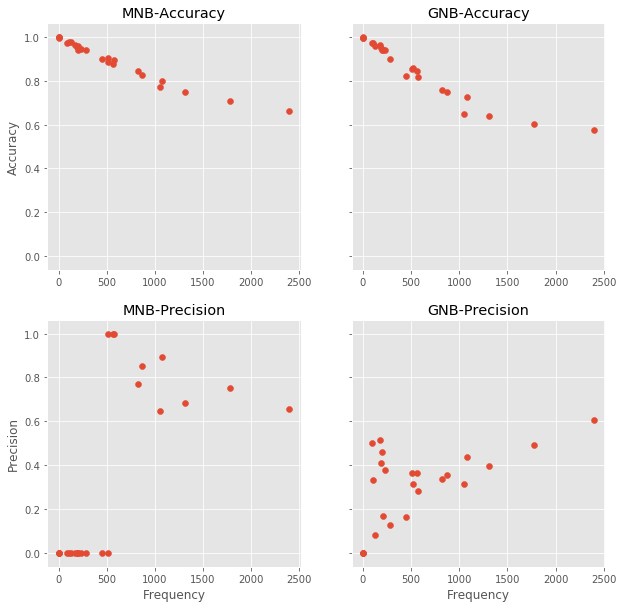

In [40]:
plt.style.use('ggplot')
fig, axs= plt.subplots(2, 2, figsize=(10,10), sharey=True)
axs[0, 0].scatter(df_MNB_score["Count"], df_MNB_score["Accuracy Score"])
axs[0, 0].set_title("MNB-Accuracy")
axs[0, 1].scatter(df_GNB_score["Count"], df_GNB_score["Accuracy Score"])
axs[0, 1].set_title("GNB-Accuracy")

axs[0, 0].set(ylabel="Accuracy")

axs[1, 0].scatter(df_GNB_score["Count"], df_MNB_score["Precision Score"])
axs[1, 0].set_title("MNB-Precision")
axs[1, 1].scatter(df_GNB_score["Count"], df_GNB_score["Precision Score"])
axs[1, 1].set_title("GNB-Precision")

axs[1, 0].set(ylabel="Precision", xlabel="Frequency")
axs[1, 1].set(xlabel="Frequency")
   

### Q2. Communication

### Q2 Extra leesmateriaal
[TF-IDF](http://www.tfidf.com)

[Understanding Multi-Label classification model and accuracy metrics](https://medium.com/towards-artificial-intelligence/understanding-multi-label-classification-model-and-accuracy-metrics-1b2a8e2648ca)

[Multi Label Text Classification with Scikit-Learn](https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5)